<center><h3>Food ratings prediction with zomato dataset</h3></center>

In [3]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import pickle

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zomato data/zomato.csv',encoding='ISO-8859-1')

In [5]:
df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,1200,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",4000,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",1500,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",1500,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [6]:
#shape of the data
df.shape

(9551, 21)

**EDA**

In [7]:
#Columns name
df.columns

Index(['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes'],
      dtype='object')

In [8]:
# Lets concat the country code with country name 
df_country=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Zomato data/Country-Code.xlsx',sheet_name=0)

In [9]:
df_country.head()

,Country Code,Country
0,1,India
1,14,Australia
2,30,Brazil
3,37,Canada
4,94,Indonesia


In [10]:
#Merged dataframe wth the country dataframe
df=pd.merge(df,df_country,on='Country Code',how='left')

In [11]:
#Dropping the country code column
df.drop(columns='Country Code',axis=1,inplace=True)

Text(0, 0.5, 'Total Count')

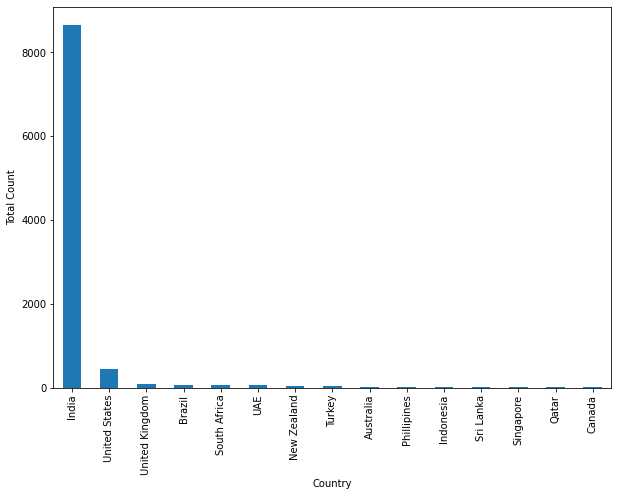

In [12]:
#Countries with number of bookings
plt.figure(figsize=(10,7))
df['Country'].value_counts().plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Total Count')

In [13]:
#Checking the null values
df.isnull().sum()

Restaurant ID           0
Restaurant Name         0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
Country                 0
dtype: int64

In [14]:
#Dropping the null values
df=df.dropna().reset_index(drop=True)

In [15]:
# Checking the currency types
df["Currency"].value_counts()

Indian Rupees(Rs.)        8652
Dollar($)                  473
Pounds(£)                  80
Brazilian Real(R$)          60
Rand(R)                     60
Emirati Diram(AED)          60
NewZealand($)               40
Turkish Lira(TL)            34
Botswana Pula(P)            22
Indonesian Rupiah(IDR)      21
Qatari Rial(QR)             20
Sri Lankan Rupee(LKR)       20
Name: Currency, dtype: int64

In [16]:
#Converting all the currencies to Indian rupees
for i in range(0,df.shape[0]):
  if df['Currency'][i]=='Dollar($)':
    df['Average Cost for two'][i]=df['Average Cost for two'][i]*73.35
  if df['Currency'][i]=='Pounds(£)':
    df['Average Cost for two'][i]=df['Average Cost for two'][i]*103.62

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
#Lets only Consider the people of India, USA ,Uk
df=df[(df['Country']=="India") | (df['Country']=='United States') | (df['Country']=='United Kingdom')]

In [18]:
#Resetting the index
df=df.reset_index(drop=True)

In [19]:
print(f'The new shape of the data is {df.shape}')
df.head()

The new shape of the data is (9157, 21)


,Restaurant ID,Restaurant Name,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes,Country
0,17284404,Austin's BBQ and Oyster Bar,Albany,"2820 Meredyth Dr, Albany, GA 31707",Albany,"Albany, Albany",-84.221535,31.610387,"BBQ, Burger, Seafood",1833,Dollar($),No,No,No,No,2,3.3,Orange,Average,35,United States
1,17284203,BJ's Country Buffet,Albany,"2401 Dawson Rd, Albany, GA 31707",Albany,"Albany, Albany",-84.207095,31.608743,"American, BBQ",733,Dollar($),No,No,No,No,1,3.3,Orange,Average,25,United States
2,17284302,El Vaquero Mexican Restaurant,Albany,"2700 Dawson Rd, Albany, GA 31707",Albany,"Albany, Albany",-84.219400,31.615800,Mexican,0,Dollar($),No,No,No,No,1,3.4,Orange,Average,45,United States
3,17284397,Elements Coffee Co - Northwest,Albany,"2726 Ledo Rd Ste 10, Albany, GA 31707",Albany,"Albany, Albany",-84.206944,31.622412,"Coffee and Tea, Sandwich",733,Dollar($),No,No,No,No,1,3.4,Orange,Average,26,United States
4,17284094,Chick-fil-A,Albany,"2703 Dawson Rd, Albany, GA 31707",Albany,"Albany, Albany",-84.219300,31.616000,Fast Food,733,Dollar($),No,No,No,No,1,3.5,Yellow,Good,67,United States


In [20]:
#Removing rows with 'Average Cost for two'==0
for i in range(0,df.shape[0]):
  if df['Average Cost for two'][i]==0:
    df.drop(i,axis=0,inplace=True)


In [21]:
df.drop_duplicates(inplace=True)

In [22]:
#Resetting the indices
df.reset_index(drop=True,inplace=True)
print(f'The new shape is {df.shape}')

The new shape is (9142, 21)


In [23]:
#Changing some of the column names
df=df.rename(columns={'Average Cost for two':'avg_cost','Has Table booking':'table_booking','Has Online delivery':'online_delivery','Restaurant Name':'restaurent_name',
                   'Aggregate rating':'ratings','Is delivering now':'is_delivering_now','Switch to order menu':'switch_to_order_menu'})

**Some Visualizations**

Text(0, 0.5, 'Price')

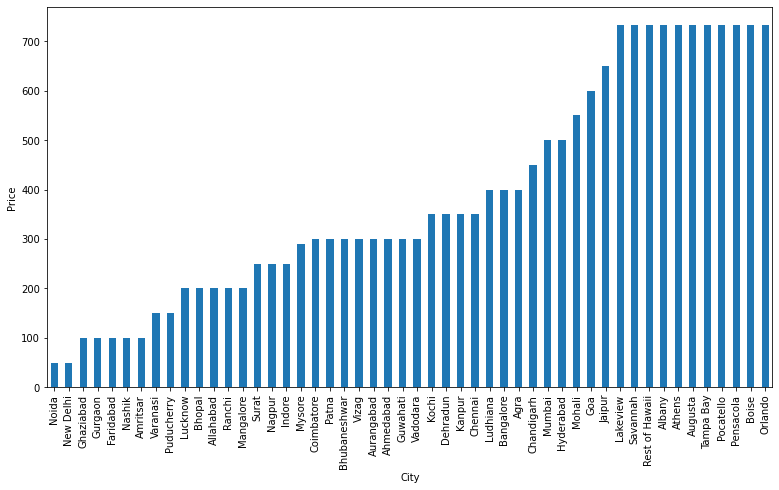

In [24]:
#Top 50 Cities with cheap Restaurents
plt.figure(figsize=(13,7))
df.groupby('City')['avg_cost'].min().sort_values(ascending=True)[0:50].plot(kind='bar')
plt.ylabel('Price')

Text(0.5, 0, '')

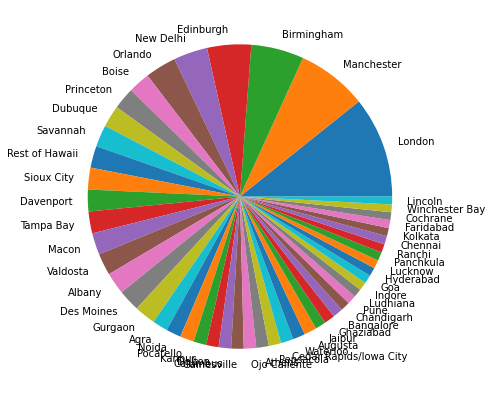

In [25]:
#Top 50 Cities with most expensive restaurents
#Note - all the prices are in INR
plt.figure(figsize=(13,7))
df.groupby('City')['avg_cost'].max().sort_values(ascending=False)[0:50].plot(kind='pie')
plt.ylabel('')
plt.xlabel('')

Text(0.5, 0, '')

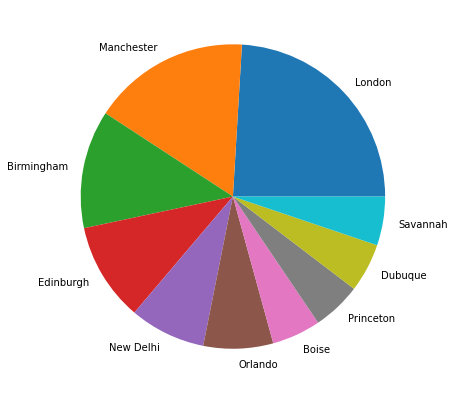

In [26]:
#Top 10 Cities with most expensive restaurents
#Note - all the prices are in INR
plt.figure(figsize=(13,7))
df.groupby('City')['avg_cost'].max().sort_values(ascending=False)[0:10].plot(kind='pie')
plt.ylabel('')
plt.xlabel('')

Text(0.5, 0, 'Ratings')

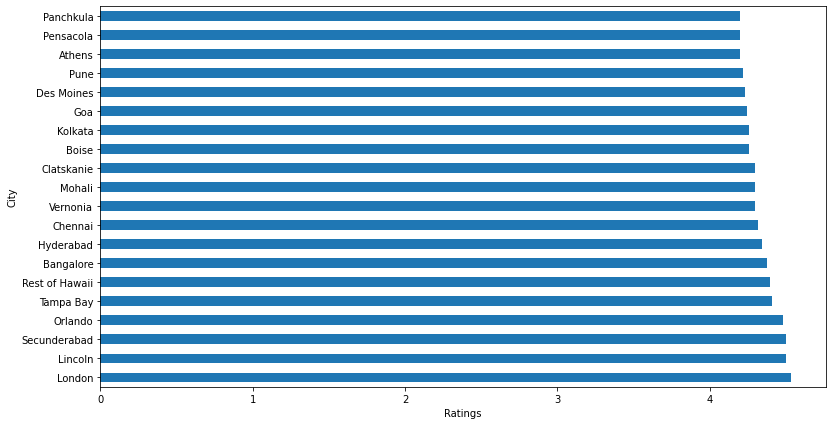

In [27]:
#  City with excellent ratings
plt.figure(figsize=(13,7))
df.groupby('City')['ratings'].mean().sort_values(ascending=False)[0:20].plot(kind='barh')
plt.ylabel('City')
plt.xlabel('Ratings')

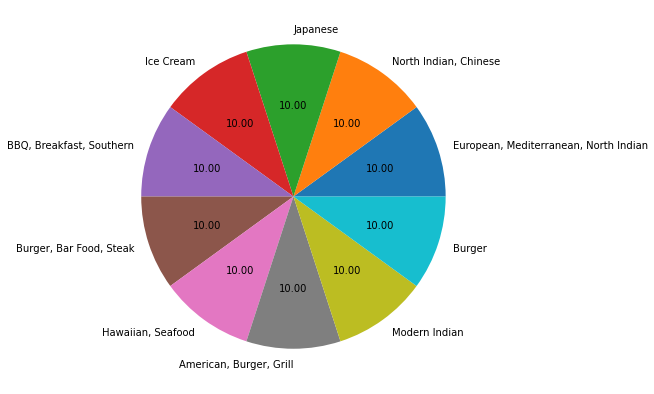

In [28]:
# Top 10 Cuisines liked by people
plt.figure(figsize=(8,7))
X=df.groupby('Cuisines')['ratings'].max().sort_values(ascending=False)[0:10].index
y=df.groupby('Cuisines')['ratings'].max().sort_values(ascending=False)[0:10].values
plt.pie(y,labels=X,autopct='%.2f')
plt.show()

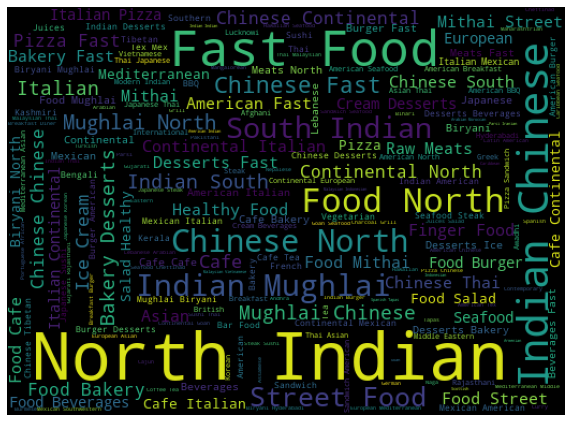

In [29]:
#Most eaten Cuisines by people
from wordcloud import WordCloud
#Function to combine all the text in a single variable
cuisine = df['Cuisines']
wc_val=""
for i in cuisine:
  wc_val=wc_val+str(i)+' '
#Displaying word cloud
plt.figure(figsize=(10,10))
wordcloud = WordCloud(background_color='black',width=520,height=380)
wordcloud.generate(wc_val)
plt.axis('off')
plt.imshow(wordcloud)

plt.show()

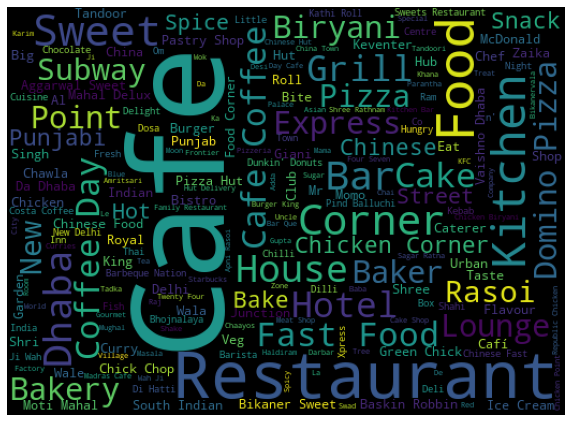

In [30]:
# Most visited restaurents by people
from wordcloud import WordCloud
#Function to combine all the text in a single variable
cuisine = df['restaurent_name']
rn_val=""
for i in cuisine:
  rn_val=rn_val+str(i)+' '
#Displaying word cloud
plt.figure(figsize=(10,10))
wordcloud = WordCloud(background_color='black',width=520,height=380)
wordcloud.generate(rn_val)
plt.axis('off')
plt.imshow(wordcloud)

plt.show()

**Selecting the features for model training**

In [31]:
df_new=df[['City','Cuisines','avg_cost','table_booking','online_delivery','ratings','is_delivering_now','Locality',"Votes",'switch_to_order_menu']]

In [32]:
df_new.head()

,City,Cuisines,avg_cost,table_booking,online_delivery,ratings,is_delivering_now,Locality,Votes,switch_to_order_menu
0,Albany,"BBQ, Burger, Seafood",1833,No,No,3.3,No,Albany,35,No
1,Albany,"American, BBQ",733,No,No,3.3,No,Albany,25,No
2,Albany,"Coffee and Tea, Sandwich",733,No,No,3.4,No,Albany,26,No
3,Albany,Fast Food,733,No,No,3.5,No,Albany,67,No
4,Albany,"Asian, Chinese, Vegetarian",733,No,No,3.9,No,Albany,141,No


**Handling Categorical features**

In [33]:
df_ohe=pd.get_dummies(data=df_new,columns=['City','Cuisines','table_booking','online_delivery','Locality','is_delivering_now',
                                           'switch_to_order_menu'],drop_first=True)

In [34]:
df_ohe

,avg_cost,ratings,Votes,City_Ahmedabad,City_Albany,City_Allahabad,City_Amritsar,City_Athens,City_Augusta,City_Aurangabad,City_Bangalore,City_Bhopal,City_Bhubaneshwar,City_Birmingham,City_Boise,City_Cedar Rapids/Iowa City,City_Chandigarh,City_Chennai,City_Clatskanie,City_Cochrane,City_Coimbatore,City_Columbus,City_Dalton,City_Davenport,City_Dehradun,City_Des Moines,City_Dubuque,City_Edinburgh,City_Faridabad,City_Fernley,City_Gainesville,City_Ghaziabad,City_Goa,City_Gurgaon,City_Guwahati,City_Hyderabad,City_Indore,City_Jaipur,City_Kanpur,City_Kochi,...,Locality_Vikaspuri,Locality_Vile Parle East,"Locality_Villa Shanti, White Town",Locality_Viman Nagar,"Locality_Vinayak City Centre Mall, Civil Lines","Locality_Vivanta by Taj, Sector 44, Gurgaon",Locality_Vivek Vihar,Locality_Vivekanand Nagar,"Locality_Vyapar Kendra, Palam Vihar","Locality_Vyapar Kendra, Sushant Lok",Locality_Vyttila,Locality_Waikiki,Locality_Wakad,"Locality_Walker's Court, Soho",Locality_Waltair Uplands,Locality_Warner Robins,Locality_Waterloo,Locality_Wazirpur,Locality_Weirton,Locality_West Des Moines,"Locality_West End Mall, Janak Puri","Locality_West Gate Mall, Rajouri Garden",Locality_West Patel Nagar,"Locality_Westend Mall, Rajguru Nagar",Locality_White Avenue,Locality_White Town,Locality_Winchester Bay,Locality_Windermere,Locality_Winter Park,"Locality_Woods Resort, Gurgaon","Locality_Worldmark 1, Aerocity","Locality_Worldmark 3, Aerocity",Locality_YN Road,Locality_Ybor City,Locality_Yusuf Sarai,"Locality_Z Square Mall, Mall Road",Locality_Zakir Nagar,Locality_Zoo Tiniali,"Locality_ibis New Delhi, Aerocity",is_delivering_now_Yes
0,1833,3.3,35,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,733,3.3,25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,733,3.4,26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,733,3.5,67,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,733,3.9,141,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,8289,4.5,602,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9138,3108,4.2,383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9139,2590,4.3,745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9140,5699,4.2,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
X=df_ohe.drop(columns='ratings')
y=df_ohe['ratings']

**Scaling**

In [36]:
#Column transformer expects list of tuples to be given in the following sequences
transformer=ColumnTransformer([('scalar',StandardScaler(),['avg_cost','Votes'])],remainder='passthrough')
X_scaled=transformer.fit_transform(X)

In [37]:
#Just for visuzlization
pd.DataFrame(X_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640,2641,2642,2643,2644,2645,2646,2647
0,1.291119,-0.269548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.011460,-0.292678,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.011460,-0.290365,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.011460,-0.195533,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.011460,-0.024375,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,8.801555,1.041899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9138,2.774361,0.535361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9139,2.171757,1.372652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9140,5.788540,-0.195533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Creating testing and validation set**

In [38]:
# Creating Testing data and training data
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.20,random_state=42)
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X_test is {X_test.shape}")

The shape of X_train is (7313, 2648)
The shape of X_test is (1829, 2648)


In [39]:
# Creating Training data and Validation data
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.10,random_state=42)
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X_val is {X_val.shape}")

The shape of X_train is (6581, 2648)
The shape of X_val is (732, 2648)


**Testing different models**

In [40]:
#https://github.com/pranaysawant/Zomato-Restaurant-Rate-Prediction/blob/master/Zomato%20Restaurant%20Rating%20Prediction.ipynb
# Random predictions
import random

rand_pred= np.zeros(y_val.shape[0])
for i in range(y_val.shape[0]):
    rand_probs = round(random.uniform(1.0, 5.0),2)
    rand_pred[i] = rand_probs


In [41]:
np.sqrt(mean_squared_error(y_val,rand_pred))

1.9470224920887416

In [42]:
# Random Forest Regressor
model_rf=RandomForestRegressor()
model_rf.fit(X_train,y_train)

RandomForestRegressor()

In [43]:
predictions_rf=model_rf.predict(X_test).round(1)

In [44]:
np.sqrt(mean_squared_error(y_test,predictions_rf))

0.3127157538419347

In [ ]:
#SVR
model_svr=SVR()
model_svr.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
predictions_svr=model_svr.predict(X_val).round(1)

In [ ]:
np.sqrt(mean_squared_error(y_val,predictions_svr))

1.0856805173679547

In [ ]:
#Lasso regression
model_lasso=SGDRegressor(penalty='l1')
model_lasso.fit(X_train,y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
predictions_lasso=model_lasso.predict(X_val).round(1)

In [ ]:
np.sqrt(mean_squared_error(y_val,predictions_lasso))

1.1576603973654862

Since Random Forest performs better out of the box in comparison to others so we hypertune the RF model

**Hyperparameter tuning**

In [ ]:
# Random Forest worked best in comparison of these two
# parameters={
#     'max_depth':[10,15,20],
#     'max_leaf_nodes':[None,7,9],
#     'n_estimators':[120,130,150],
#     'min_samples_leaf':[1,3]
# }

In [ ]:
model_search=GridSearchCV(model_rf,parameters,scoring='neg_root_mean_squared_error',cv=3,verbose=1,n_jobs=-1)

NameError: ignored

In [ ]:
model_search.fit(X_train,y_train)

In [ ]:
model_search.best_score_

In [ ]:
model_search.best_params_

In [ ]:
{'max_depth': 20,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'n_estimators': 150}

**Feature Engineering**

In [45]:
# Creating a new feature cost per person* votes
df_new['cpp_votes']=(df_new['avg_cost']/2)*df_new['Votes']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
df_new.head()

,City,Cuisines,avg_cost,table_booking,online_delivery,ratings,is_delivering_now,Locality,Votes,switch_to_order_menu,cpp_votes
0,Albany,"BBQ, Burger, Seafood",1833,No,No,3.3,No,Albany,35,No,32077.5
1,Albany,"American, BBQ",733,No,No,3.3,No,Albany,25,No,9162.5
2,Albany,"Coffee and Tea, Sandwich",733,No,No,3.4,No,Albany,26,No,9529.0
3,Albany,Fast Food,733,No,No,3.5,No,Albany,67,No,24555.5
4,Albany,"Asian, Chinese, Vegetarian",733,No,No,3.9,No,Albany,141,No,51676.5


In [47]:
#Defining the X and y
X=df_new.drop(columns='ratings')
y=df_new['ratings']

In [48]:
X_dummies=pd.get_dummies(X,columns=['City','Cuisines','table_booking','online_delivery','is_delivering_now','Locality','switch_to_order_menu'],
               drop_first=True)

In [49]:
transformer=ColumnTransformer([('scalar',StandardScaler(),['avg_cost','Votes','cpp_votes'])],
     remainder='passthrough'
)
X_scaled=transformer.fit_transform(X_dummies)

In [50]:
X_train2,X_test2,y_train2,y_test2=train_test_split(X_scaled,y,test_size=0.20,random_state=42)

In [51]:
# Random Forest Regressor
model_rf_final=RandomForestRegressor(max_depth= 20,n_estimators=150)
model_rf_final.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=20, n_estimators=150)

In [52]:
predictions_rf2=model_rf_final.predict(X_test2).round(1)

In [53]:
np.sqrt(mean_squared_error(y_test2,predictions_rf2))

0.31360616144179815

**Creating a pipeline for deployment**

In [54]:
transformer=ColumnTransformer([('ohe',OneHotEncoder(),['City','Cuisines','table_booking','online_delivery','is_delivering_now','Locality','switch_to_order_menu']),
                                ('scalar',StandardScaler(),['avg_cost','Votes','cpp_votes'])],
                                remainder='passthrough')
model_rf=RandomForestRegressor(max_depth= 20,n_estimators=150)

In [55]:
X_pipe=df_new.drop(columns='ratings')
y_pipe=df_new['ratings']
X_train_pipe,X_test_pipe,y_train_pipe,y_test_pipe=train_test_split(X_pipe,y_pipe,test_size=0.20,random_state=42)

In [56]:
#Pipeline also accepts a list of tuples
pipeline_rf=Pipeline([('Column_transformer',transformer),('rf',model_rf)])

In [57]:
#Transforming the training data
transformed_train_data=pipeline_rf.fit(X_pipe,y_pipe)

In [58]:
# Checking the predictions
predictions_final=pipeline_rf.predict(X_test_pipe).round(1)
print(f"The rmse is {np.sqrt(mean_squared_error(y_test_pipe,predictions_final))}")

The rmse is 0.209975394950022


**Dumping the piepline**

In [59]:
pickle.dump(pipeline_rf,open('pipeline_zomato.pkl','wb'))

**Loading the model again for testing**

In [60]:
model_test=pickle.load(open('/content/pipeline_zomato.pkl','rb'))

In [61]:
#Creating a dataset for testing
data={
    'City':['Albany'],
    'Cuisines':['American, BBQ'],
    'avg_cost':[733],
    'table_booking':['No'],
    'online_delivery':['No'],
    'is_delivering_now':['No'],
    'Locality':['Albany'],
    'Votes':[25],
    'switch_to_order_menu':['No'],
    'cpp_votes':[9162.5]
}
test_data=pd.DataFrame(data)

In [62]:
print(f"The predicted value is :- {model_test.predict(test_data)}")
print(f"The actual value is {y_pipe[0]}")

The predicted value is :- [3.22773044]
The actual value is 3.3


**Creating requirements.txt**

In [63]:
pip freeze > requirements.txt

<h3>Conclusion</h3>

We have build a Random Forest model will root mean squared error to be approx 0.3 , then a pipeline has been created for the transformations and scaling .This dumped pipeline will be used for deploying the model.